# Wildfire Impact Estimate in Pueblo, CO
## Notebook 4: Association Between Smoke Intensity and Public Health Outcomes

In this notebook, I explore [data](https://coepht.colorado.gov/asthma-data) published by the Colorado Department of Public Health and Environment on the rates of hospitalization related to asthma. I examine whether there is a link between wildfire smoke intensity and asthma incidence.

## Motivation

The [CDC points out](https://www.cdc.gov/climate-health/php/regions/northeast.html#:~:text=During%20this%20event%2C%20New%20York,is%20a%20known%20asthma%20trigger.) that "[e]xposure to wildfire smoke has been shown to lead to several negative health outcomes and is a known asthma trigger." Therefore, I was interested in studying whether my smoke intensity estimate and the incidence of asthma were positively associated. I hypothesized that smoke intensity and any metric of asthma incidence – such as hospitalization or emergency room visits – would have a positive relationship.

Understanding this relationship is important to the human-centered goals of this project. If there is a positive association between the intensity of wildfire smoke and the incidence of asthma, this information is potentially valuable to Pueblo policymakers. They could leverage projections of smoke intensity in the future, use the (hypothesized) positive association between smoke intensity and asthma incidence to prioritize people living with asthma for various public health interventions, like distributing masks or ensuring adequate numbers of hospital beds are available when wildfires strike.

## Data Availability

I was inspired to conduct this analysis by a [CDC study](https://www.cdc.gov/mmwr/volumes/72/wr/mm7234a6.htm) which found that "[a]sthma-associated [emergency department] visits increased over 80% on the **day** with the highest exposure to wildfire smoke" (emphasis mine). To replicate this study in Pueblo, it would obviously be ideal to have access to **daily** data describing both wildfire smoke intensity and asthma incidence.

The state of Colorado publishes two metrics related to asthma incidence, but only for recent years:
- Asthma hospitalizations (2004-2023, 20 years of data, available monthly and yearly)
- Emergency department visits (2011-2023, 13 years of data, available monthly and yearly)

**Unfortunately, we are limited to yearly resolution in the smoke intensity estimate**, since the smoke intensity estimate is reliant on "fire polygon data [which] only (reliably) provide a year for each fire - [they do] not (reliably) provide specific start and end dates for the fire" ([McDonald 2024](https://docs.google.com/document/d/1DRchxt4-mGkQ__zQe-7yif-XvU31s8zMePa82oBz3ek/edit?tab=t.0)). 

Therefore, any association between the smoke intensity estimate and the incidence of asthma is limited to yearly resolution. Wildfire data runs until 2020; this means there are 17 years in which I have a smoke intensity estimate AND asthma hospitalization data. It also means that there are only 10 years in which I have wildfire data AND emergency department visit data. Since we are limited to yearly granularity, this also means we're restricted to 17 and 10 *data points*, respectively. Small sample sizes hurt the reliability of linear regression and time series analyses. **Therefore, I omit emergency department visits and focus exclusively on testing the relationship between estimated smoke intensity and asthma hospitalizations from 2004-2020.**


## Exploring the Asthma Data

I begin with standard imports...

In [177]:
# import dependencies
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import numpy as np

In [178]:
asthma_df = pd.read_excel("../raw_data/colorado_epht_data/TEEO_REF_CDPHE COEPHT Asthma Data 2011-2022_2023_EN.xlsx",
                          sheet_name="HOSP AA Asthma 2004-2022")

asthma_df.head(5)

,COUNTY,RATE,L95CL,U95CL,HOSP,FLAG,YEAR,GENDER,MEASURE,HEALTHOUTCOMEID,cofips
0,Statewide,10.457399,10.035516,10.879282,2379.0,2,2004,Female,Age adjusted rate,Asthma,8000
1,Statewide,8.780078,8.385680,9.174476,1965.0,2,2004,Male,Age adjusted rate,Asthma,8000
2,Statewide,9.680240,9.390356,9.970124,4344.0,2,2004,Both genders,Age adjusted rate,Asthma,8000
3,Statewide,11.081077,10.650148,11.512007,2567.0,2,2005,Female,Age adjusted rate,Asthma,8000
4,Statewide,8.025286,7.645202,8.405371,1790.0,2,2005,Male,Age adjusted rate,Asthma,8000


Data is reported for all of Colorado's counties and by gender, so I do some filtering to isolate the relevant data:

In [179]:
# filter down to just the relevant data
pueblo_asthma = asthma_df.loc[(asthma_df["COUNTY"] == "Pueblo") & 
                              (asthma_df["GENDER"] == "Both genders") & 
                              (asthma_df["GENDER"] == "Both genders")]

# I also have to do some wrangling to ensure years are stored in datetime format, which
# will make it easier to join this data with smoke intensity data later
years = [str(y) for y in pueblo_asthma["YEAR"]]
years = pd.to_datetime(years)
pueblo_asthma.loc[:,"DATE"] = years
pueblo_asthma = pueblo_asthma.set_index("DATE")
pueblo_asthma = pueblo_asthma[["RATE"]]

/var/folders/4b/m5nrgw957519qfykv2lpzg_80000gp/T/ipykernel_91532/3917014002.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pueblo_asthma.loc[:,"DATE"] = years


The first thing I want to do is plot the data to understand any trend in Asthma hospitalizations over time:

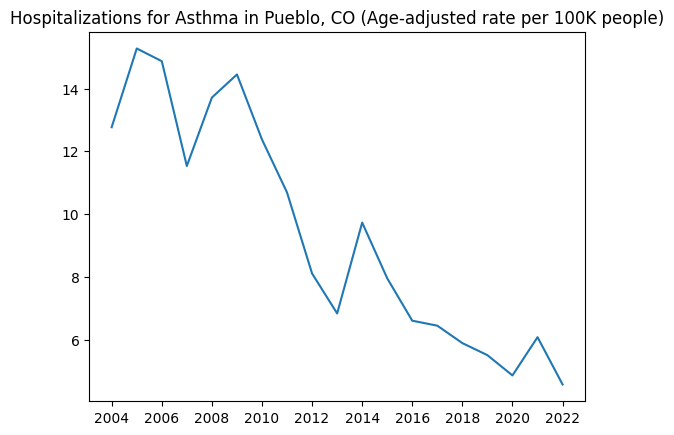

In [180]:
plt.plot(pueblo_asthma.index, pueblo_asthma["RATE"])
plt.title("Hospitalizations for Asthma in Pueblo, CO (Age-adjusted rate per 100K people)")
plt.show()

Already, I notice something pretty surprising in this data: although I know the Smoke Intensity Estimate has reached high values in recent years, **hospitalizations for asthma in Pueblo, CO** are more or less in constant decline. To be sure this is the case, I want to visually overlay the hospitalization rate and the smoke intensity estimate. 

I'll also calculate the correlation between the two to get a quantitative sense for how they are related.

In [181]:
# import the smoke intensity data created in Notebook 3 and stored in intermediate_data
sie_aqi_df = pd.read_csv("../intermediate_data/yearly_sie_aqi.csv")

# transform year column to right format to ensure join operation succeeds
sie_aqi_df["year"] = pd.to_datetime(sie_aqi_df["year"])
sie_aqi_df = sie_aqi_df.set_index("year")

# join smoke intensity data and asthma data
df_for_viz = sie_aqi_df.join(pueblo_asthma)

In [182]:
# compute correlation between smoke intensity index and the age-adjusted rate of
# asthma hospitalizations in Pueblo
corr_matx = df_for_viz.corr()
corr = corr_matx.loc["fie", "RATE"]

corr_ = str(round(corr,2))
corr_ # store as variable so that I can put it in the title of the plot in the next cell

'-0.32'

With my data processed, I plot the two series on a single chart:

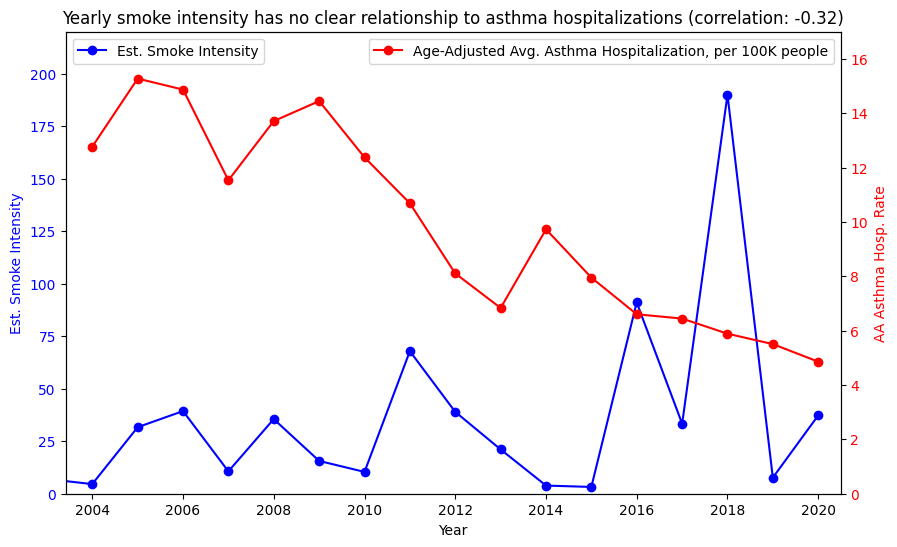

In [183]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(df_for_viz.index, df_for_viz['fie'], color='b', label='Est. Smoke Intensity', marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('Est. Smoke Intensity', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title(f'Yearly smoke intensity has no clear relationship to asthma hospitalizations (correlation: {corr_})')

ax1.set_xlim(pd.Timestamp('2003-06-01'), pd.Timestamp('2020-06-30'))
ax1.set_ylim(0, 220)

ax2 = ax1.twinx()
ax2.plot(df_for_viz.index, df_for_viz['RATE'], color='r', label='Age-Adjusted Avg. Asthma Hospitalization, per 100K people', marker='o')
ax2.set_ylabel('AA Asthma Hosp. Rate', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(0, 17)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

It turns out that my hypothesis – yearly smoke intensity and asthma hospitalization rate positively associated – is not supported by the yearly smoke intensity and asthma hospitalization data. This is also clear from a scatterplot:

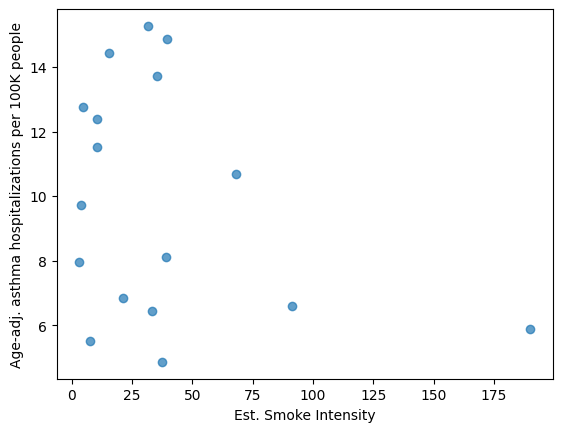

In [184]:
plt.scatter(df_for_viz['fie'], df_for_viz['RATE'], alpha=0.7)
plt.xlabel('Est. Smoke Intensity')
plt.ylabel('Age-adj. asthma hospitalizations per 100K people')
plt.show()

Clearly, there is no positive relationship between smoke intensity and asthma hospitalizations in Pueblo over this timeframe. If anything, the relationship is slightly negative (but not linear).

Returning to the figure overlaying smoke intensity and asthma hospitalizations, it is clear that there is a long-term trend of lower asthma rates over time. This is great news for the residents of Pueblo, but it may stand in the way of properly testing my hypothesis. For example, effective public health interventions could be driving the consistent decline in asthma rates. If that effect is the predominant force affecting asthma rates, the impact of wildfire smoke could be drowned out by that steady decrease – even through wildfire smoke *could* still be causing spikes *relative* to that declining trend.

To test whether this could be the case, I need to de-trend the asthma hospitalization data. (Since smoke intensity does not exhibit a clear trend between 2004-2020, I will not detrend this series.)

There are a few approaches I could take to detrend the asthma data, including:
- Calculating a moving average and subtracting its value each year to get the residual asthma rate
- Taking the difference between asthma rates in sucessive years and treating that as the residual asthma rate
- Fitting a linear model and subtracting its value each year to get the residual asthma rate
    - I was concerned that doing this would violate the assumptions of linear regression, but read a [StackExchange post](https://stats.stackexchange.com/questions/261038/why-is-it-valid-to-detrend-time-series-with-regression) that convinced me it is valid

With so few data points, calculating a useful moving average is difficult. So I opted for the other two choices.

### Detrending with a linear model

First, I use a linear model to estimate the trend in the decline of asthma rates over time:

In [185]:
# the years for which we have data
x = np.arange(2004,2021)
y = df_for_viz["RATE"][-len(x):] # take the last N years, where N is the years btw. 2004 and 2020

x_with_const = sm.add_constant(x)

linear_model = sm.OLS(y,x_with_const).fit()

print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   RATE   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     86.99
Date:                Wed, 04 Dec 2024   Prob (F-statistic):           1.24e-07
Time:                        01:20:40   Log-Likelihood:                -29.053
No. Observations:                  17   AIC:                             62.11
Df Residuals:                      15   BIC:                             63.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1331.6721    141.723      9.396      0.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=17 observations were given.
  return hypotest_fun_in(*args, **kwds)


The linear model here represents the trend component of the time series – on average, asthma hospitalizations rates are declining by around 0.7 people per 100K people each year. But we want to strip out the trend component and see how yearly hospitalizations vary around this trend:

In [186]:
trend = linear_model.predict() # this gives the model's prediction for trend-level asthma each year

detrended_asthma = y - trend # detrend asthma by subtracting trend

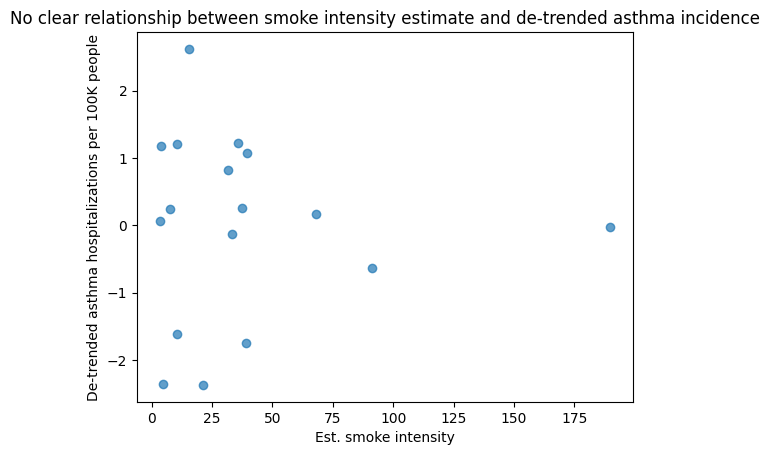

In [187]:
plt.scatter(df_for_viz["fie"].iloc[-len(detrended_asthma):], detrended_asthma, alpha=0.7)
plt.title("No clear relationship between smoke intensity estimate and de-trended asthma incidence")
plt.xlabel("Est. smoke intensity")
plt.ylabel("De-trended asthma hospitalizations per 100K people")
plt.show()

From the scatterplot, there appears to be no relationship. To be sure, I'll take things a step further and fit a linear model between the *smoke estimate* and the de-trended asthma. If my original hypothesis is correct, I expect a positive, linear relationship between these variables:

/var/folders/4b/m5nrgw957519qfykv2lpzg_80000gp/T/ipykernel_91532/4006192064.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = x[sorted_indices]


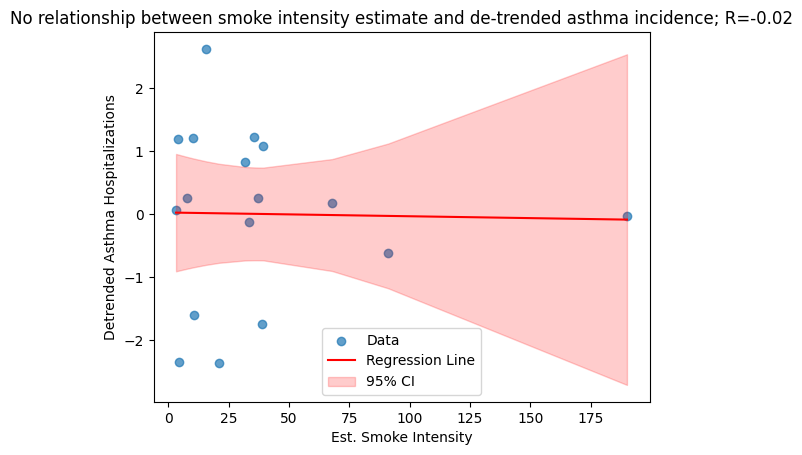

In [188]:
# Fit a linear regression model to smoke and asthma
x = df_for_viz["fie"].iloc[-len(detrended_asthma):]
y = detrended_asthma

corr_ = np.corrcoef(x,y)[1,0]

# have to add this for the model to have an intercept term
x_with_const = sm.add_constant(x)

model = sm.OLS(y, x_with_const).fit()

# generate confidence interals
predictions = model.get_prediction(x_with_const)
predicted_values = predictions.predicted_mean
ci_lower, ci_upper = predictions.conf_int().T # put lower and upper bounds in plot-friendly format

# have to sort or else these don't plot properly
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
predicted_values_sorted = predicted_values[sorted_indices]
ci_lower_sorted = ci_lower[sorted_indices]
ci_upper_sorted = ci_upper[sorted_indices]

# Scatterplot
plt.scatter(x, y, label="Data", alpha=0.7)
plt.title(f"No relationship between smoke intensity estimate and de-trended asthma incidence; R={round(corr_,2)}")
plt.xlabel("Est. Smoke Intensity")
plt.ylabel("Detrended Asthma Hospitalizations")

# Add the regression line on top of the scatterplot
plt.plot(x_sorted, predicted_values_sorted, color="red", label="Regression Line")

# Color in the bands representing confints
plt.fill_between(x_sorted, ci_lower_sorted, ci_upper_sorted, color="red", alpha=0.2, label="95% CI")

# Add legend
plt.legend()

# Show plot
plt.show()

This scatterplot shows conclusively that, even after adjusting for the steady decline in asthma hospitalizations over time, the yearly data does not support the hypothesized positive relationship between smoke intensity and asthma hospitalizations.

### Detrending with Differencing

With differencing, we come to the same conclusion – a very weak correlation between smoke intensity and detrended asthma rate.

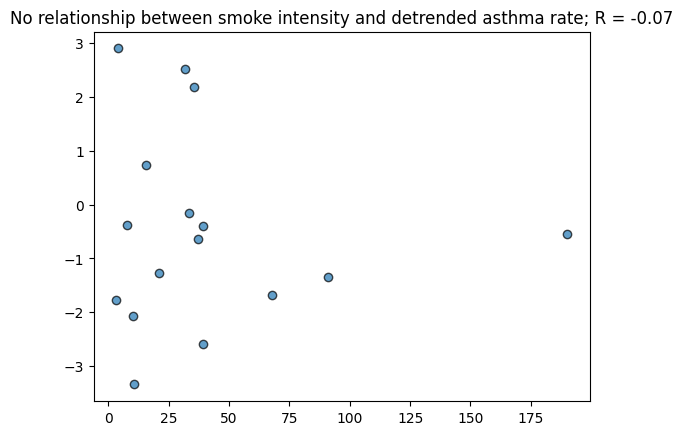

In [189]:
years = np.arange(2004, 2021)
residual_asthma = df_for_viz["RATE"].iloc[-len(years):].diff()

x = df_for_viz["fie"].iloc[-len(years)+1:]
y = residual_asthma[1:]


corr_ = np.corrcoef(x,y)[0,1]

plt.scatter(x,y, alpha=0.7, edgecolor="black")
plt.title(f"No relationship between smoke intensity and detrended asthma rate; R = {round(corr_,2)}")
plt.show()

After incorporating detrending into the analysis, I am left to conclude that the data does not support a positive association, at a yearly level, between my estimate of smoke intensity and the rate of asthma hospitalizations in Pueblo, CO.

In my final report, I explore reasons for this surprising result at length. Briefly, they may include:
- My smoke intensity estimate is simply not a good estimate – it does not capture what it's supposed to measure
- Aggregation bias – even if it is true that *daily* (monthly) asthma hospitalizations peak on *days* (months) when wildfire smoke peaks, this trend may not show up when we average over many days (months) to get yearly data, since other trends are also at play

# Appendix: CO Poisoning Data

As I explored public health variables that could be plausibly linked to wildfire smoke, I also came across carbon monoxide poisoning data. Similar to asthma, I hypothesized a positive relationship between estimated smoke intensity and carbon monoxide poisoning. Unfortunately, the data for carbon monoxide poisoning in Pueblo is too sparse to draw any conclusions:

In [190]:
co_poisoning = pd.read_excel("../raw_data/colorado_epht_data/TEEO_REF_CDPHE COEPHT Carbon Monoxide Poisoning Data 2011-2022_2023_EN.xlsx", 
                             sheet_name="HOSP AA Carbon Monoxide 2004-22")

# analogous filtering to asthma table above
pueblo_co = co_poisoning.loc[(co_poisoning["COUNTY"] == "Pueblo") & 
                              (co_poisoning["GENDER"] == "Both genders") & 
                              (co_poisoning["GENDER"] == "Both genders")]

pueblo_co.head(15)


,COUNTY,RATE,L95CL,U95CL,HOSP,FLAG,YEAR,GENDER,MEASURE,HEALTHOUTCOMEID,cofips
8894,Pueblo,NaN,NaN,NaN,NaN,2,2004,Both genders,Age adjusted rate,Total unintended carbon monoxide poisoning,8101
8897,Pueblo,NaN,NaN,NaN,NaN,2,2005,Both genders,Age adjusted rate,Total unintended carbon monoxide poisoning,8101
8900,Pueblo,NaN,NaN,NaN,NaN,2,2006,Both genders,Age adjusted rate,Total unintended carbon monoxide poisoning,8101
8903,Pueblo,0.0,0.0,0.0,0.0,2,2007,Both genders,Age adjusted rate,Total unintended carbon monoxide poisoning,8101
8906,Pueblo,NaN,NaN,NaN,NaN,2,2008,Both genders,Age adjusted rate,Total unintended carbon monoxide poisoning,8101
8909,Pueblo,NaN,NaN,NaN,NaN,2,2009,Both genders,Age adjusted rate,Total unintended carbon monoxide poisoning,8101
8912,Pueblo,NaN,NaN,NaN,NaN,2,2010,Both genders,Age adjusted rate,Total unintended carbon monoxide poisoning,8101
8915,Pueblo,NaN,NaN,NaN,NaN,2,2011,Both genders,Age adjusted rate,Total unintended carbon monoxide poisoning,8101
8918,Pueblo,NaN,NaN,NaN,NaN,2,2012,Both genders,Age adjusted rate,Total unintended carbon monoxide poisoning,8101
8921,Pueblo,0.0,0.0,0.0,0.0,2,2013,Both genders,Age adjusted rate,Total unintended carbon monoxide poisoning,8101
